In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import time
import os
from PIL import Image


In [11]:
# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 10

print("Welcome to Autonomous Vehicle Perception!")
print("=" * 60)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: CPU (Intel Iris Xe Graphics)")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print("All packages loaded successfully!")
print("=" * 60)

Welcome to Autonomous Vehicle Perception!
PyTorch version: 2.8.0+cpu
Device: CPU (Intel Iris Xe Graphics)
NumPy version: 2.2.6
OpenCV version: 4.12.0
All packages loaded successfully!


## Understanding Camera Data

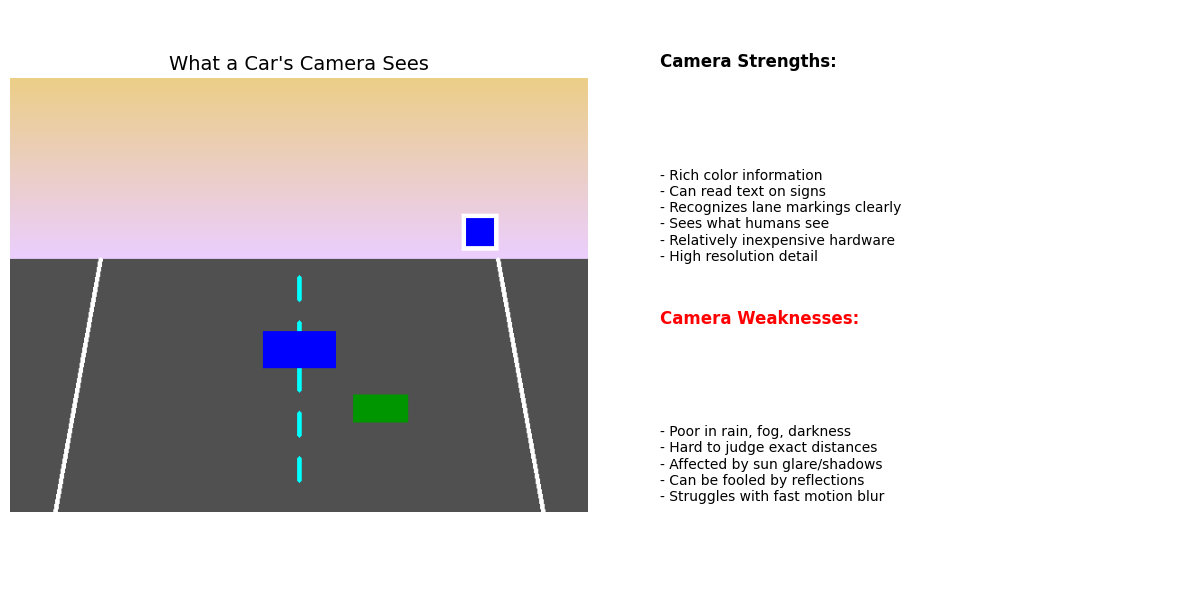

Cameras give us rich visual information but struggle with distance and weather!


In [3]:
# Cell 2: Camera Data - What Do Car Cameras See?

def create_realistic_road_scene():
    """
    Create a simulated road scene like what a car's front camera would capture
    """
    height, width = 480, 640  # Typical camera resolution
    img = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Sky gradient (blue fading to lighter blue)
    for y in range(200):
        blue_intensity = 135 + int((255-135) * (y/200))
        img[y, :] = [blue_intensity, 206, 235]
    
    # Road surface (gray asphalt)
    road_gray = [80, 80, 80]
    img[200:, :] = road_gray
    
    # Lane lines with perspective (lines get closer as they go further)
    # Left lane boundary
    cv2.line(img, (100, 200), (50, 479), (255, 255, 255), 4)
    # Right lane boundary
    cv2.line(img, (540, 200), (590, 479), (255, 255, 255), 4)
    
    # Center dashed line (yellow)
    for i in range(5):
        y_start = 220 + i * 50
        y_end = y_start + 25
        if y_end < height:
            cv2.line(img, (320, y_start), (320, y_end), (255, 255, 0), 3)
    
    # Add vehicles as obstacles
    cv2.rectangle(img, (280, 280), (360, 320), (255, 0, 0), -1)  # Red car ahead
    cv2.rectangle(img, (380, 350), (440, 380), (0, 150, 0), -1)  # Green car in other lane
    
    # Traffic sign
    cv2.rectangle(img, (500, 150), (540, 190), (255, 255, 255), -1)  # Sign background
    cv2.rectangle(img, (505, 155), (535, 185), (255, 0, 0), -1)     # Red stop sign
    
    return img

# Create and display the camera image
camera_image = create_realistic_road_scene()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(camera_image, cv2.COLOR_BGR2RGB))
plt.title("What a Car's Camera Sees", fontsize=14)
plt.axis('off')

# Add explanation
plt.subplot(1, 2, 2)
plt.text(0.1, 0.9, "Camera Strengths:", fontsize=12, weight='bold', transform=plt.gca().transAxes)
camera_strengths = """
- Rich color information
- Can read text on signs
- Recognizes lane markings clearly  
- Sees what humans see
- Relatively inexpensive hardware
- High resolution detail
"""

plt.text(0.1, 0.75, camera_strengths, fontsize=10, transform=plt.gca().transAxes, va='top')

plt.text(0.1, 0.45, "Camera Weaknesses:", fontsize=12, weight='bold', transform=plt.gca().transAxes, color='red')
camera_weaknesses = """
- Poor in rain, fog, darkness
- Hard to judge exact distances
- Affected by sun glare/shadows
- Can be fooled by reflections
- Struggles with fast motion blur
"""

plt.text(0.1, 0.3, camera_weaknesses, fontsize=10, transform=plt.gca().transAxes, va='top')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Cameras give us rich visual information but struggle with distance and weather!")

## Understanding LiDAR Data

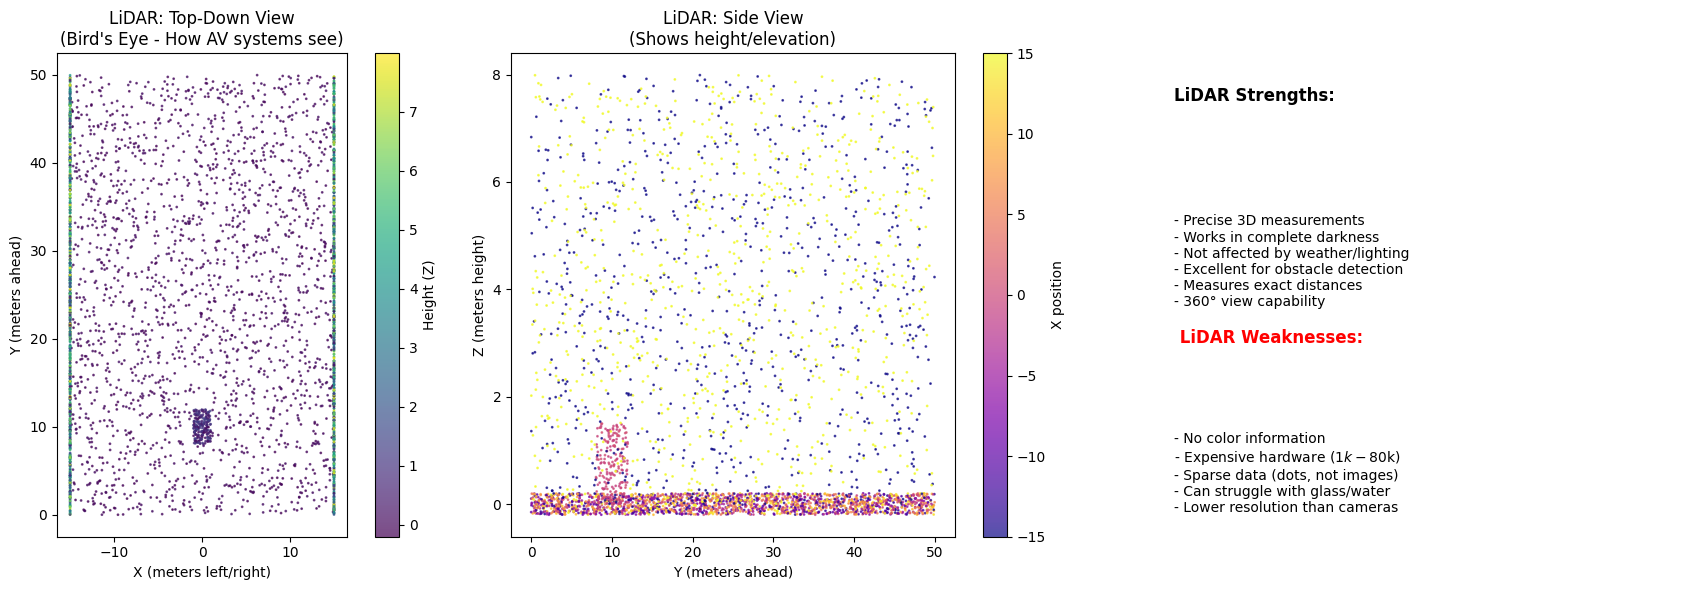

 LiDAR gives precise 3D measurements but lacks visual detail!
Generated 3,800 3D points representing the scene


In [4]:
# Create LIDAR 3D Point Cloud data points

def create_lidar_road_scene():
    """
    Create LiDAR point cloud data representing the same road scene
    LiDAR shoots laser beams and measures distances to create 3D points
    """
    np.random.seed(42)  # For consistent results
    
    # Road surface points (mostly flat, z ≈ 0)
    road_x = np.random.uniform(-15, 15, 2000)  # Left-right spread
    road_y = np.random.uniform(0, 50, 2000)    # Distance ahead
    road_z = np.random.uniform(-0.2, 0.2, 2000)  # Nearly flat road
    
    # Car ahead (3D box of points)
    car_x = np.random.uniform(-1, 1, 200)      # Car width
    car_y = np.random.uniform(8, 12, 200)      # Distance ahead
    car_z = np.random.uniform(0, 1.5, 200)    # Car height
    
    # Buildings/walls on left side
    left_wall_x = np.full(800, -15)            # Fixed x position
    left_wall_y = np.random.uniform(0, 50, 800)
    left_wall_z = np.random.uniform(0, 8, 800) # Building height
    
    # Buildings/walls on right side
    right_wall_x = np.full(800, 15)
    right_wall_y = np.random.uniform(0, 50, 800)
    right_wall_z = np.random.uniform(0, 8, 800)
    
    # Combine all points into one array
    all_x = np.concatenate([road_x, car_x, left_wall_x, right_wall_x])
    all_y = np.concatenate([road_y, car_y, left_wall_y, right_wall_y])
    all_z = np.concatenate([road_z, car_z, left_wall_z, right_wall_z])
    
    points = np.column_stack((all_x, all_y, all_z))
    return points

# Create LiDAR data
lidar_points = create_lidar_road_scene()

# Visualize LiDAR from different angles
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Top-down view (bird's eye) - most common for autonomous driving
scatter1 = axes[0].scatter(lidar_points[:, 0], lidar_points[:, 1], 
                          c=lidar_points[:, 2], cmap='viridis', s=1, alpha=0.7)
axes[0].set_title("LiDAR: Top-Down View\n(Bird's Eye - How AV systems see)", fontsize=12)
axes[0].set_xlabel("X (meters left/right)")
axes[0].set_ylabel("Y (meters ahead)")
axes[0].set_aspect('equal')
plt.colorbar(scatter1, ax=axes[0], label="Height (Z)")

# Side view - shows height information
scatter2 = axes[1].scatter(lidar_points[:, 1], lidar_points[:, 2], 
                          c=lidar_points[:, 0], cmap='plasma', s=1, alpha=0.7)
axes[1].set_title("LiDAR: Side View\n(Shows height/elevation)", fontsize=12)
axes[1].set_xlabel("Y (meters ahead)")
axes[1].set_ylabel("Z (meters height)")
plt.colorbar(scatter2, ax=axes[1], label="X position")

# Explanation
axes[2].text(0.1, 0.9, "LiDAR Strengths:", fontsize=12, weight='bold', transform=axes[2].transAxes)
lidar_strengths = """
- Precise 3D measurements
- Works in complete darkness
- Not affected by weather/lighting
- Excellent for obstacle detection
- Measures exact distances
- 360° view capability
"""

axes[2].text(0.1, 0.7, lidar_strengths, fontsize=10, transform=axes[2].transAxes, va='top')

axes[2].text(0.1, 0.4, " LiDAR Weaknesses:", fontsize=12, weight='bold', 
             transform=axes[2].transAxes, color='red')
lidar_weaknesses = """
- No color information
- Expensive hardware ($1k-$80k)
- Sparse data (dots, not images)
- Can struggle with glass/water
- Lower resolution than cameras
"""

axes[2].text(0.1, 0.25, lidar_weaknesses, fontsize=10, transform=axes[2].transAxes, va='top')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(" LiDAR gives precise 3D measurements but lacks visual detail!")
print(f"Generated {len(lidar_points):,} 3D points representing the scene")

## The Multi-Modal Advantage

MULTI-MODAL FUSION: Best of Both Worlds


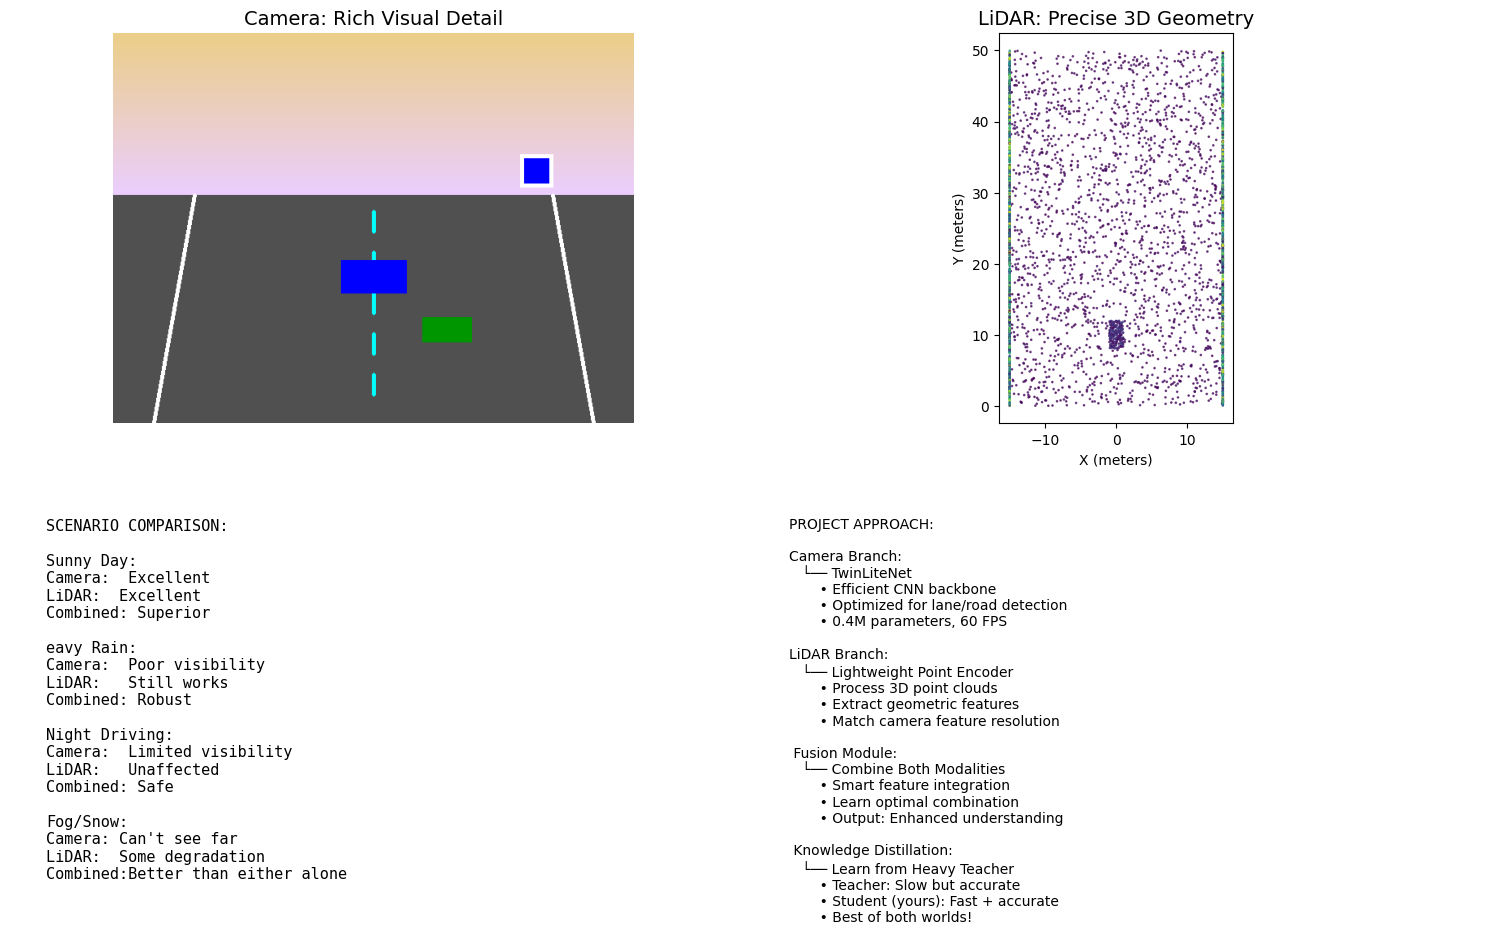


Multi-Modal Fusion Advantages:
1. Redundancy: If one sensor fails, the other continues working
2. Complementary info: Camera sees details, LiDAR measures distances
3. Weather robustness: Combined system works in more conditions
4. Better accuracy: More information leads to better decisions
5. Safety critical: Autonomous driving requires multiple confirmation sources

 This is why the project combines TwinLiteNet (camera) + LiDAR processing!


In [5]:
# Why Combine Camera + LiDAR?

print("MULTI-MODAL FUSION: Best of Both Worlds")
print("="*60)

# Side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Camera image
axes[0,0].imshow(cv2.cvtColor(camera_image, cv2.COLOR_BGR2RGB))
axes[0,0].set_title("Camera: Rich Visual Detail", fontsize=14)
axes[0,0].axis('off')

# LiDAR bird's eye view
scatter = axes[0,1].scatter(lidar_points[:, 0], lidar_points[:, 1], 
                           c=lidar_points[:, 2], cmap='viridis', s=0.8, alpha=0.7)
axes[0,1].set_title("LiDAR: Precise 3D Geometry", fontsize=14)
axes[0,1].set_xlabel("X (meters)")
axes[0,1].set_ylabel("Y (meters)")
axes[0,1].set_aspect('equal')

# Scenario comparison table
axes[1,0].axis('off')
scenario_data = """
SCENARIO COMPARISON:

Sunny Day:
Camera:  Excellent
LiDAR:  Excellent
Combined: Superior

eavy Rain:
Camera:  Poor visibility
LiDAR:   Still works
Combined: Robust

Night Driving:
Camera:  Limited visibility  
LiDAR:   Unaffected
Combined: Safe

Fog/Snow:
Camera: Can't see far
LiDAR:  Some degradation
Combined:Better than either alone
"""

axes[1,0].text(0.05, 0.95, scenario_data, transform=axes[1,0].transAxes, 
               fontsize=11, va='top', ha='left', family='monospace')

# Project approach
axes[1,1].axis('off')
project_approach = """
PROJECT APPROACH:

Camera Branch:
   └── TwinLiteNet
       • Efficient CNN backbone
       • Optimized for lane/road detection
       • 0.4M parameters, 60 FPS

LiDAR Branch:  
   └── Lightweight Point Encoder
       • Process 3D point clouds
       • Extract geometric features
       • Match camera feature resolution

 Fusion Module:
   └── Combine Both Modalities
       • Smart feature integration
       • Learn optimal combination
       • Output: Enhanced understanding

 Knowledge Distillation:
   └── Learn from Heavy Teacher
       • Teacher: Slow but accurate
       • Student (yours): Fast + accurate
       • Best of both worlds!
"""

axes[1,1].text(0.05, 0.95, project_approach, transform=axes[1,1].transAxes,
               fontsize=10, va='top', ha='left')

plt.tight_layout()
plt.show()

print("\nMulti-Modal Fusion Advantages:")
advantages = [
    "Redundancy: If one sensor fails, the other continues working",
    "Complementary info: Camera sees details, LiDAR measures distances", 
    "Weather robustness: Combined system works in more conditions",
    "Better accuracy: More information leads to better decisions",
    "Safety critical: Autonomous driving requires multiple confirmation sources"
]

for i, advantage in enumerate(advantages, 1):
    print(f"{i}. {advantage}")

print(f"\n This is why the project combines TwinLiteNet (camera) + LiDAR processing!")

## Segmentation Tasks (Pixel-wise Classification)

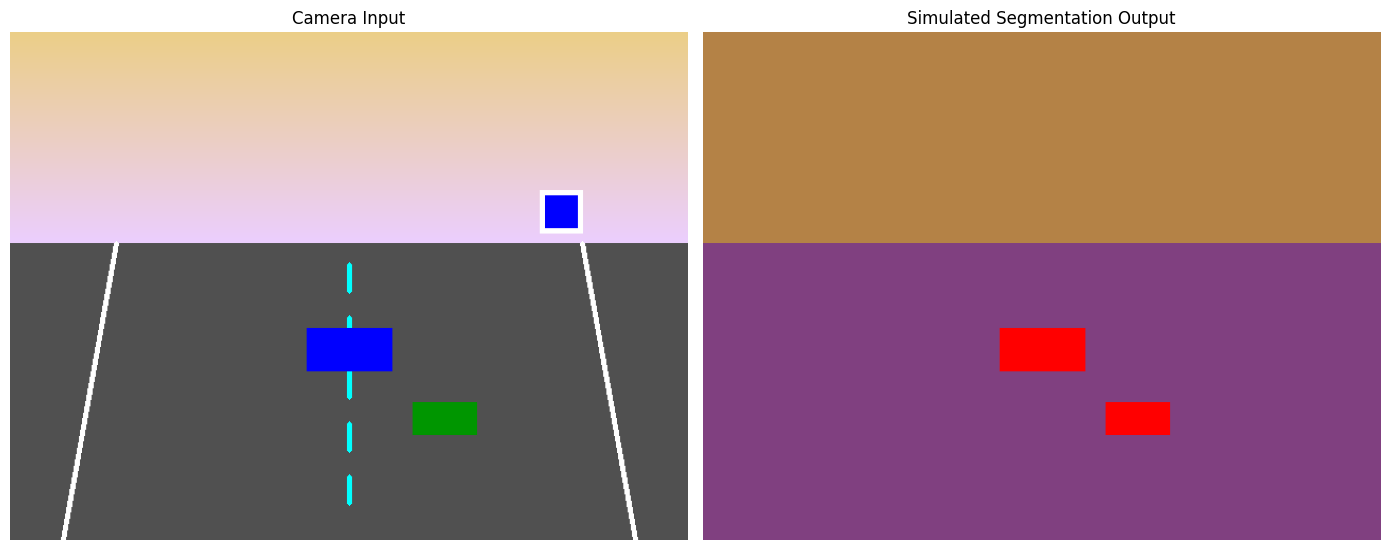

In [6]:

# Create a blank segmentation mask with same shape as image
segmentation_mask = np.zeros_like(camera_image)

# Simulated classes with fixed colors:
# - Road: purple
# - Vehicle: red
# - Sky: blue

# Paint road area (bottom half)
segmentation_mask[200:, :] = [128, 64, 128]  # Road (purple)

# Paint cars (same as in original image)
cv2.rectangle(segmentation_mask, (280, 280), (360, 320), (0, 0, 255), -1)   # Red car
cv2.rectangle(segmentation_mask, (380, 350), (440, 380), (0, 0, 255), -1)   # Green car (overridden with red mask)

# Paint sky (top area)
segmentation_mask[:200, :] = [70, 130, 180]  # Sky (blue)

# Display both camera image and simulated segmentation
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Original input
axs[0].imshow(cv2.cvtColor(camera_image, cv2.COLOR_BGR2RGB))
axs[0].set_title("Camera Input")
axs[0].axis('off')

# Segmentation output
axs[1].imshow(cv2.cvtColor(segmentation_mask, cv2.COLOR_BGR2RGB))
axs[1].set_title("Simulated Segmentation Output")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Semantic segmentation is the task of assigning a **class label to each pixel** in an image.

In the simulation, we classify pixels into 3 categories:
- **Road**: Purple color `[128, 64, 128]`
- **Vehicles**: Red color `[0, 0, 255]`
- **Sky**: Blue color `[70, 130, 180]`

Real models like `DeepLab`, `BiSeNet`, or `TwinLiteNet` can learn this task from real data.


## IoU Metrics — How to Measure Segmentation Accuracy

### What is IoU?

**IoU** (Intersection over Union) is a metric used to evaluate how well a **segmentation model** predicts each class (like roads, vehicles, sky, etc.).

It is calculated as:

$
\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$



### Why Use IoU?

- Gives **class-wise accuracy**, not just total pixel count
- Helps spot **under/over-segmentation**
- Used in datasets like **Cityscapes**, **KITTI**, **nuScenes**
- Tougher and more realistic than simple pixel accuracy


### How It Works:

Let's say we want to segment "car pixels":

- `True mask`: Where the **car actually is**
- `Predicted mask`: Where your **model thinks** the car is

We compute:
- **Intersection** = pixels both agree on (true positive)
- **Union** = all pixels marked by either as car

Then IoU is:

$
\text{IoU}_{\text{car}} = \frac{\text{Intersection}}{\text{Union}}
$


### Goal:
- A perfect segmentation = IoU of `1.0`
- Bad segmentation = IoU close to `0.0`
- Target: **Mean IoU (mIoU) > 0.5** is a decent baseline

We'll compute IoU for:
- Road `[128, 64, 128]`
- Vehicle `[0, 0, 255]`
- Sky `[70, 130, 180]`

Let’s calculate it using our simulated segmentation mask!


In [7]:
# Compute IoU for road, vehicle, and sky

def compute_iou(pred_mask, true_mask, class_color):
    """
    Compute IoU for a given class color in predicted and ground truth masks.
    """
    pred_binary = np.all(pred_mask == class_color, axis=-1)
    true_binary = np.all(true_mask == class_color, axis=-1)
    
    intersection = np.logical_and(pred_binary, true_binary).sum()
    union = np.logical_or(pred_binary, true_binary).sum()

    iou = intersection / union if union > 0 else 1.0  # Avoid division by zero
    return iou

# For simulation, assume ground truth == prediction
true_mask = segmentation_mask.copy()

# Define color codes
ROAD_COLOR = [128, 64, 128]
VEHICLE_COLOR = [0, 0, 255]
SKY_COLOR = [70, 130, 180]

# Compute IoUs
road_iou = compute_iou(segmentation_mask, true_mask, ROAD_COLOR)
vehicle_iou = compute_iou(segmentation_mask, true_mask, VEHICLE_COLOR)
sky_iou = compute_iou(segmentation_mask, true_mask, SKY_COLOR)

# Mean IoU
miou = np.mean([road_iou, vehicle_iou, sky_iou])

# Display results
print("IoU Results:")
print(f"Road IoU:     {road_iou:.2f}")
print(f"Vehicle IoU:  {vehicle_iou:.2f}")
print(f"Sky IoU:      {sky_iou:.2f}")
print(f"Mean IoU:     {miou:.2f}")


IoU Results:
Road IoU:     1.00
Vehicle IoU:  1.00
Sky IoU:      1.00
Mean IoU:     1.00


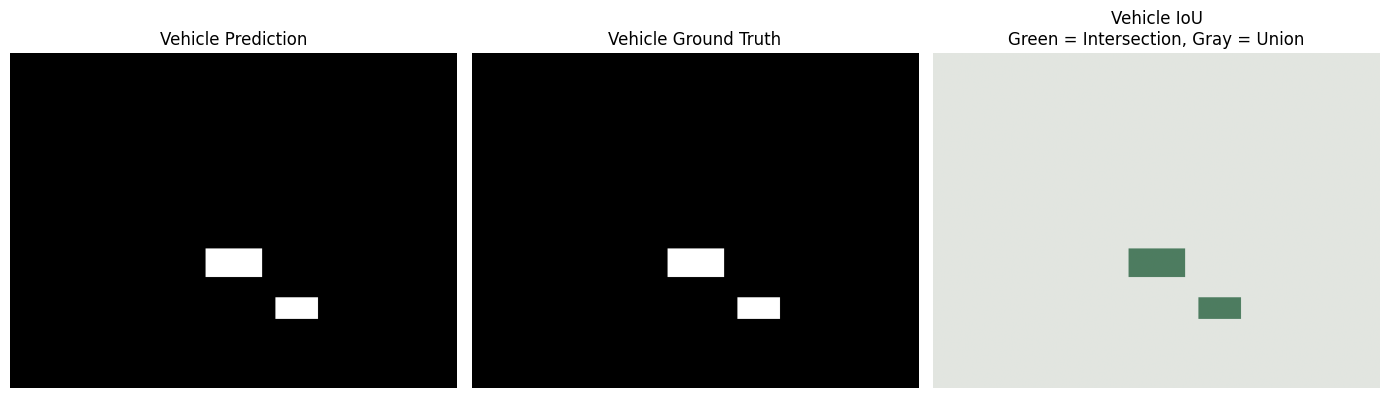

In [8]:
# Visualize how intersection and union look for a class (e.g., vehicles)

def visualize_iou_for_class(pred_mask, true_mask, class_color, label="Vehicle"):
    pred_binary = np.all(pred_mask == class_color, axis=-1)
    true_binary = np.all(true_mask == class_color, axis=-1)
    
    intersection = np.logical_and(pred_binary, true_binary)
    union = np.logical_or(pred_binary, true_binary)

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    axs[0].imshow(pred_binary, cmap='gray')
    axs[0].set_title(f"{label} Prediction")
    axs[0].axis('off')
    
    axs[1].imshow(true_binary, cmap='gray')
    axs[1].set_title(f"{label} Ground Truth")
    axs[1].axis('off')
    
    axs[2].imshow(union, cmap='gray', alpha=0.3)
    axs[2].imshow(intersection, cmap='Greens', alpha=0.7)
    axs[2].set_title(f"{label} IoU\nGreen = Intersection, Gray = Union")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Example: visualize IoU for vehicle class
visualize_iou_for_class(segmentation_mask, true_mask, VEHICLE_COLOR, label="Vehicle")
